# 8장:컨볼루션을 활용한 일반화

In [2]:
#| output: false
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

from torchvision import datasets, transforms
data_path = '../data-unversioned/p1ch6/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(), # 토텐서 변환
        transforms.Normalize((0.4915, 0.4823, 0.4468), # 평균과 표준편차를 가지고 정규화
                             (0.2470, 0.2435, 0.2616))
    ]))

cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

Files already downloaded and verified
Files already downloaded and verified


## 8.1 컨볼루션

- 비행기 같은 물체와 일치하는 패턴을 인지하려면 인근 픽셀의 배열 방식을 살펴봐야한다
- 이 개념을 수학적인 형태로 바꾸려면 이미지 내의 다른 픽셀이 아닌 바로 옆 픽셀에 대한 가중치의 합을 계산하면 된다
- 출력 픽셀 위치마다 가중치 행렬을 만든는 것인데 센터가 되는 픽셀에서 일정 거리 떨어진 경우 가중치가 0이 되는 구조, 계산 결과는 여전히 가중치의 합이므로 선형 연산임

`-` translation invariance(평행이동 불변성): 지역화된 패턴이 이미지의 어떤 위치에 있더라도 동일하게 출력에 영향을 주는 성질

- 7장에서 했던 일차원 벡터는 패턴을 찾기 위해선 다소 복잡한 가중치 패턴 구현이 필요
- 이미지에 대해 지역적인, 평행이동 불변성을 보장하는 선형 연산 -> 컨볼루션

> 이산 컨볼루션은 2차원 이미지에 가중치 행렬을 스칼라곱을 수행하는 것으로 정의, 가중치 행렬은 *커널*이라고 부름

- 커널의 크기는 일반적으로 모든 방향으로 동일하게 만듬
- kernel_size = 3
- in_ch (입력 피처): RGB 채널을 가지니 픽셀당 3개의 입력 피처
- out_ch(출력 피처): 임의로 16을 전달

In [6]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

`-` weight 텐서의 차원 정보

- 커널은 3 x 3 이므로 가중치 역시 3 x 3 사용
- 출력 픽셀 값 하나에 대한 커널: in_ch x 3 x 3
- 그리고 이 값을 출력 채널만큼 가지게 된다: out_ch = 16
- 전체 가중치 텐서 out_ch x in_ch x 3 x 3
- out_ch x in_ch x kernel_size x kernel_size

In [4]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [7]:
# 출력 이미지 가중합
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape # 기존 이미지의 차원(C x H x W), 컨볼루션 전달 후 차원

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

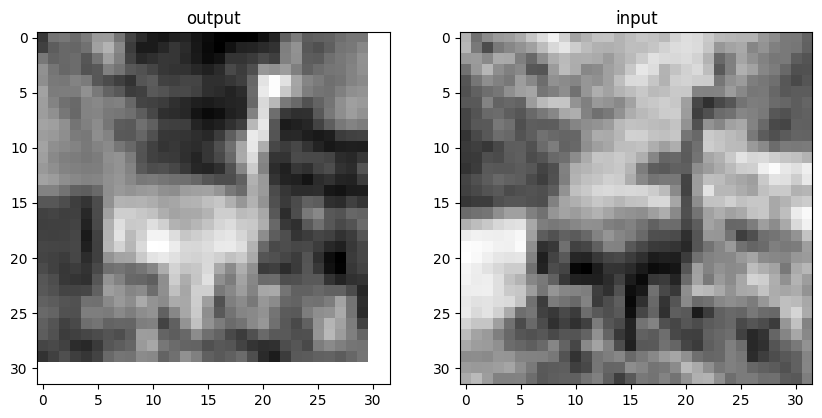

In [6]:
# 이미지의 크기가 줄어든 것을 확인할 수 있다.
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F2_PyTorch.png')  # bookskip
plt.show()

## 8.2 경계 패딩하기

- 3 x 3 이웃 영역에 대해 컨볼루션 커널을 가중합으로 적용하려면 일단 모든 방향에 값이 존재한다는 가정이 있어야 한다!!
- padding=1 을 통해 가짜 픽셀을 패딩한다

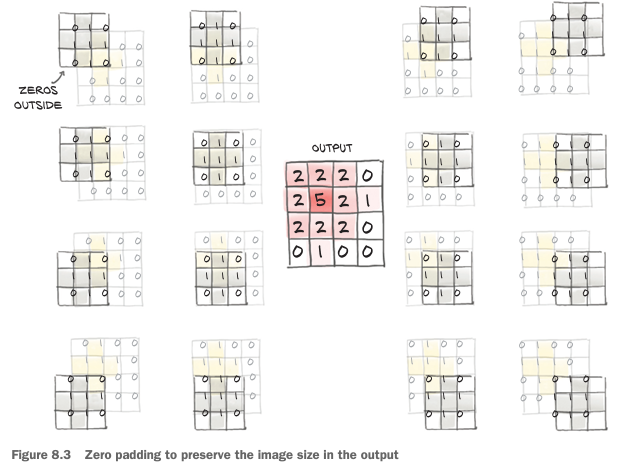

In [8]:
# 패딩시킨 코드 
conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

> bias는 0으로 제거해 교란 변수를 배제, 가중치에 상수값을 넣어서 출력에서 각 픽셀이 자신의 이웃 픽셀에 대한 평균을 가지게 해보자

In [8]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

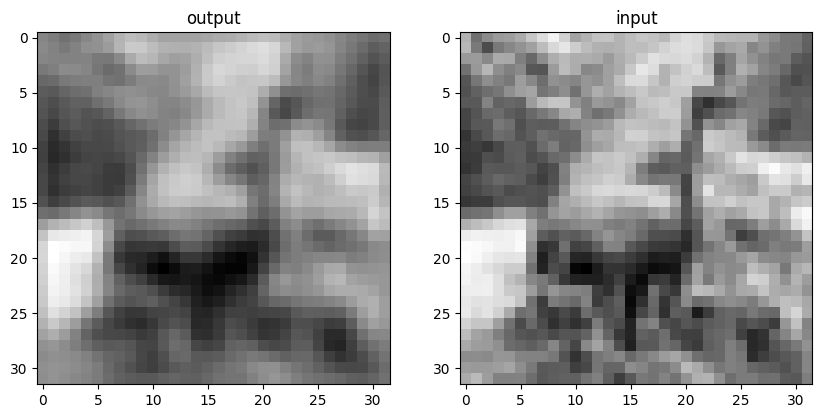

In [9]:
#  가중치는 이웃 픽셀에 대한 평균
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

In [81]:
(-0.2001*0.9156-0.1735*1.4658+0.0442*0.9604+0.0695)/0.0222

-14.665683783783782

In [74]:
conv = nn.Conv2d(3, 1, kernel_size=2, padding=1)

In [75]:
conv.weight

Parameter containing:
tensor([[[[ 0.1812,  0.1955],
          [ 0.1995, -0.2001]],

         [[-0.1721, -0.0878],
          [ 0.0529, -0.1735]],

         [[-0.1613,  0.0608],
          [-0.1309,  0.0442]]]], requires_grad=True)

In [76]:
conv.bias

Parameter containing:
tensor([0.0222], requires_grad=True)

In [77]:
output

tensor([[[[ 0.9156,  1.1696,  1.2331,  0.5663],
          [-0.3228,  0.8838,  1.2014,  1.2649],
          [ 1.2966,  0.2011,  0.4869,  1.3125],
          [ 1.0743,  0.4551,  0.5504,  0.9791]],

         [[ 1.4658,  1.8040,  2.0294,  1.1437],
          [ 0.5156,  1.6912,  1.7718,  1.8040],
          [ 1.6107,  0.4995,  1.4658,  1.7718],
          [ 1.1759,  0.9665,  1.2886,  1.6590]],

         [[ 0.9604,  1.1853,  1.4701,  0.3158],
          [-0.7635,  1.2602,  1.3352,  1.0953],
          [ 1.5600,  0.9304,  0.8405,  0.9454],
          [ 1.3502, -0.1189, -0.0140,  0.1059]]]])

In [73]:
conv(output)

tensor([[[[-0.0695, -0.2537, -0.2587, -0.5608, -0.4635],
          [ 0.0061,  0.4689,  0.4658, -0.0940, -0.5199],
          [ 0.0787,  0.6408,  0.4002,  0.3023, -0.6798],
          [ 0.8647, -0.5524, -0.2736,  0.1320, -0.6747],
          [ 0.3528, -0.2184,  0.2578,  0.4575, -0.1202]]]],
       grad_fn=<ConvolutionBackward0>)

In [30]:
img.unsqueeze(0).shape

torch.Size([1, 3, 32, 32])

In [31]:
conv(img.unsqueeze(0))

tensor([[[[ 0.3902,  0.2728,  ...,  0.3474,  0.1872],
          [ 0.3793,  0.1530,  ...,  0.1958,  0.0754],
          ...,
          [-0.0650,  0.0541,  ...,  0.0807,  0.2762],
          [ 0.1024,  0.3440,  ..., -0.0268,  0.1232]]]],
       grad_fn=<ConvolutionBackward0>)

In [68]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)

with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

In [69]:
pool = nn.MaxPool2d(8)
output = pool(img.unsqueeze(0))
output.shape

torch.Size([1, 3, 4, 4])

In [57]:
1.1696+0.8838+1.8040+1.6912+1.1853+1.2602

7.9941

In [54]:
output

tensor([[[[ 0.9156,  1.1696,  1.2331,  0.5663],
          [-0.3228,  0.8838,  1.2014,  1.2649],
          [ 1.2966,  0.2011,  0.4869,  1.3125],
          [ 1.0743,  0.4551,  0.5504,  0.9791]],

         [[ 1.4658,  1.8040,  2.0294,  1.1437],
          [ 0.5156,  1.6912,  1.7718,  1.8040],
          [ 1.6107,  0.4995,  1.4658,  1.7718],
          [ 1.1759,  0.9665,  1.2886,  1.6590]],

         [[ 0.9604,  1.1853,  1.4701,  0.3158],
          [-0.7635,  1.2602,  1.3352,  1.0953],
          [ 1.5600,  0.9304,  0.8405,  0.9454],
          [ 1.3502, -0.1189, -0.0140,  0.1059]]]])

In [55]:
conv.weight

Parameter containing:
tensor([[[[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-1.,  0.,  1.],
          [-1.,  0.,  1.]]]], requires_grad=True)

In [56]:
conv(output)

tensor([[[[  7.9941,   6.2700,  -1.8042,  -9.0409],
          [  9.6251,   4.5957,   0.5945, -11.8341],
          [  6.7690,   1.4295,   4.1689,  -8.9265],
          [  2.9337,  -3.4496,   3.8400,  -4.6182]]]],
       grad_fn=<ConvolutionBackward0>)

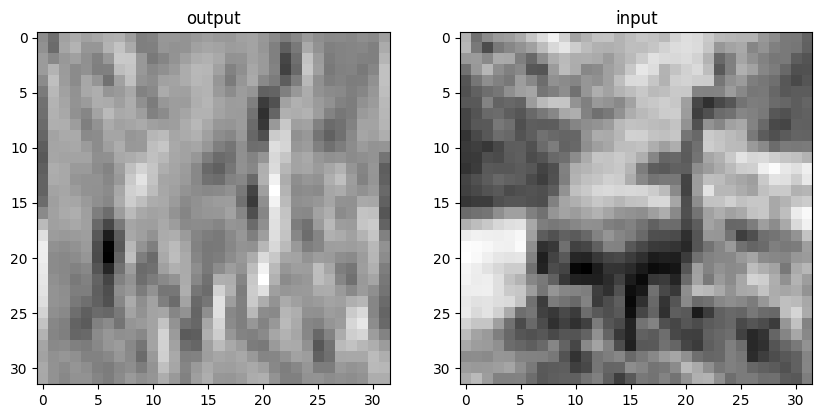

In [23]:
# 가로로 인접한 두 영역 사이의 수직 경계를 탐색하는 가중치
output = conv(img.unsqueeze(0))
plt.figure(figsize=(10, 4.8))  # bookskip
ax1 = plt.subplot(1, 2, 1)   # bookskip
plt.title('output')   # bookskip
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1)  # bookskip
plt.imshow(img.mean(0), cmap='gray')  # bookskip
plt.title('input')  # bookskip
plt.savefig('Ch8_F4_PyTorch.png')  # bookskip
plt.show()

## 이미지가 매우 클 때는?

> kernel_size가 3 또는 5를 사용했는데 이미지가 크다면 지역성의 한계를 가진다

1. 더 큰 컨볼루션 커널을 사용 -> 컨볼루션의 장점을 잃어버리게 된다.
2. 다운샘플링! 

`-` 다운샘플링
- 네 개의 픽셀을 평균: 초기에는 평균 풀링을 많이 사용했지만 요즘은 잘 사용하지 않는다
- 네 개의 픽셀 중 최댓값: 맥스 풀링은 요즘에 많이 사용하지만, 데이터의 3/4을 버린다는 단점
- 맥스 풀링: nn.MaxPool2d 모듈에 있다. 입력으로 풀링 연산을 수행할 인접한 영역 크기를 받음
- nn.MaxPool2d(2) -> 크기를 절반으로 줄임

In [11]:
# pool은 이미지 절반으로 줄인다
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

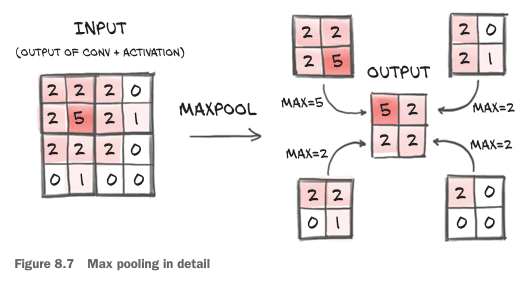

> 더 나은 성능을 위해 컨볼루션과 다운샘플링 결합

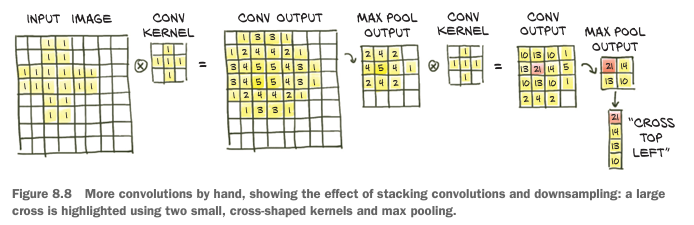

In [12]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...
            )

In [14]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1), # 8개 채널로 출력
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... 뭔가 중요한게 하나 빠졌다!
            nn.Linear(8 * 8 * 8, 32), # 8
            nn.Tanh(),
            nn.Linear(32, 2))

- 선형 계층의 크기가 MaxPool2d의 출력 크기 8 x 8 x 8 에 의존
- (C x H x W 구조) 초기: 3 x 32 x 32 -> (두 번의 맥스 풀링, 마지막 Conv2d의 출력 피처:8) 8 x 8 x 8
- 

In [9]:
model(img.unsqueeze(0))

tensor([[0.0908, 0.0938]], grad_fn=<AddmmBackward0>)

- RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)
- 위같은 에러가 생기는 이유는 8 x 8 이미지를 512요소를 가진 1차원 벡터로 차원 정보를 변경해야 한다

## 8.3 nn.Module 서브클래싱하기

- 이번 절의 핵심내용은 nn.Module의 서브클래스를 직접 만드는 법을 배워서 이미 만들어져 있는 것이나 nn.Sequential처럼 사용한다
- nn.Module을 서브클래싱하려면 먼저 forward 함수를 정의하여 모듈로 입력을 전달하고 출력을 전달하게 해야 한다
- torch 연산을 사용하기만 한다면 자동미분 기능이 자동으로 역방향 경로를 만들어준다.
- 그래서 nn.Module에는 backward가 필요 없다

> 뒤에서 만들 연산도 결국은 컨볼루션 같은 이미 있는 모듈을 사용한다. 이 서브 모듈을 포함하려면 생성자 __init__에 정의하고 self에 할당해서 forward 함수에서 사용할 수 있게 만들어야 한다.

- 이렇게 하면 모듈이 동작하는 동안 파라미터가 유지될 것이다. 모든 코드에 앞서 super().init__()를 호출해야 한다!

In [ ]:
model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ... 무언가가 빠졌다.
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

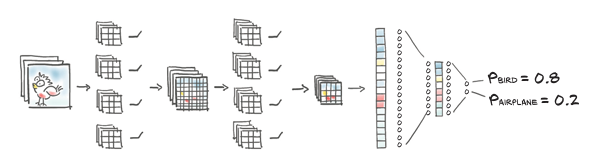

In [20]:
class Net(nn.Module):  # Net 클래스는 nn.Sequential과 같은 서브모듈
    def __init__(self):
        super().__init__() # 모든 코드의 앞에서 필수!!
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8 * 8 * 8) # 앞에서 놓쳤던 차원 정보 변경
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

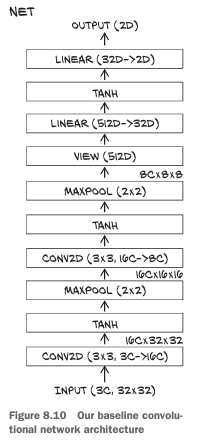

> 앞에서 정의한 Net과 동일하면서도 훨씬 더 간결하다. 생성자에서의 초기화를 위한 파라미터 입력은 필요

In [10]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) # 컨볼루션 3C -> 16C 로 변환
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1) # 컨볼루션 16C -> 8C 로 변환
        self.fc1 = nn.Linear(8 * 8 * 8, 32) # 선형 변환
        self.fc2 = nn.Linear(32, 2) # 선형 변환
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2) # 컨볼루션 -> 활성함수(tanh) -> 맥스풀링(2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2) # 컨볼루션 -> 활성함수(tanh) -> 맥스풀링(2)
        out = out.view(-1, 8 * 8 * 8) # 차원정보 맞추기 8C x 8 x 8 -> 512d
        out = torch.tanh(self.fc1(out))  # 선형변환 -> 활성함수(tanh)
        out = self.fc2(out) # 최종 선형변환(2개의 아웃풋)
        return out

- ```__init__(self)``` 메서드는 주로 객체가 생성될 때 초기화 작업을 수행하는데 사용
- 여기서는 주로 뉴럴 네트워크의 각 레이어들을 정의하고 초기화하는 역할

> 따라서 ```__init__``` 메서드는 보통 신경망의 레이어를 선언하고 초기화하는 부분으로 생각할 수 있습니다. 반면에 forward 메서드에서는 이러한 레이어들을 통과하면서 입력에서 출력까지의 계산과정이 구현되어 있습니다.

In [11]:
# 모델 점검
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0139,  0.1372]], grad_fn=<AddmmBackward0>)

## 8.4 컨볼루션 신경망 훈련시키기

1. 모델에 입력값 입력(순방향)
2. 손실값 계산(순방향)
3. 이전 기울기값 0으로 리셋
4. loss.backward() 호출하여 모든 파라미터에 대한 손실값의 기울기를 계산(역방향)
5. 이후 옵티마이저를 통해 손실값을 낮추도록 파라미터를 조정

In [12]:
model = Net()
model(img.unsqueeze(0))

tensor([[0.2268, 0.2497]], grad_fn=<AddmmBackward0>)

In [13]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        for imgs, labels in train_loader:  # 훈련 데이터 입력
            
            outputs = model(imgs)  # 모델에 이미지 입력
            
            loss = loss_fn(outputs, labels)  # 손실 함수 계산

            optimizer.zero_grad()  # 이전 기울기값 지우기
            
            loss.backward()  # 역전파 수행. 즉 모든 파라미터에 대한 기울기 계산
            
            optimizer.step()  # 모델 업데이트

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [14]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)  

model = Net()  #  신경망 초기화
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  경사 하강법
loss_fn = nn.CrossEntropyLoss()  #  크로스엔트로피 손실값(LogSoftmax와 NLLLoss의 조합)

training_loop(  # 훈련 루프 호출
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-03-07 14:27:50.762727 Epoch 1, Training loss 0.5920039126827459
2024-03-07 14:27:57.233376 Epoch 10, Training loss 0.3260749121000812
2024-03-07 14:28:04.245433 Epoch 20, Training loss 0.2971180685006889
2024-03-07 14:28:11.297717 Epoch 30, Training loss 0.27208930899383155
2024-03-07 14:28:18.794419 Epoch 40, Training loss 0.25611254653543425
2024-03-07 14:28:26.076065 Epoch 50, Training loss 0.23912156472919852
2024-03-07 14:28:33.461875 Epoch 60, Training loss 0.22134561794009178
2024-03-07 14:28:40.881375 Epoch 70, Training loss 0.20697098775843906
2024-03-07 14:28:48.126675 Epoch 80, Training loss 0.19211664933497738
2024-03-07 14:28:55.208202 Epoch 90, Training loss 0.176260754347417
2024-03-07 14:29:02.376236 Epoch 100, Training loss 0.1619067371461042


In [15]:
# 정확도 측정
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, val_loader)

Accuracy train: 0.92
Accuracy val: 0.88


## 모델을 저장하고 불러오기

In [16]:
# 저장
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [17]:
# 불러오기
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

## GPU에서 훈련시키기

- nn.Module도 .to 메소드가 있어서 모든 파라미터를 GPU로 옮길 수 있다
- 

In [18]:
# device 변수 설정
device = (torch.device('cuda') if torch.cuda.is_available()
          else torch.device('cpu'))

print(f"Training on device {device}.")

Training on device cuda.


In [19]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)  # imgs와 labels를 옮기는 이 두 줄만 다르다
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [20]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=True)

model = Net().to(device=device)  # 모델(파라미터)을 GPU로 옮긴다
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2024-03-07 14:34:04.002323 Epoch 1, Training loss 0.5633499166768068
2024-03-07 14:34:06.638765 Epoch 10, Training loss 0.32738773534252386
2024-03-07 14:34:09.595797 Epoch 20, Training loss 0.29067508349562904
2024-03-07 14:34:12.572088 Epoch 30, Training loss 0.26694642757154574
2024-03-07 14:34:15.544828 Epoch 40, Training loss 0.24837728585027585
2024-03-07 14:34:18.628061 Epoch 50, Training loss 0.2286462817507185
2024-03-07 14:34:21.607041 Epoch 60, Training loss 0.214210810317735
2024-03-07 14:34:24.608404 Epoch 70, Training loss 0.19998175247459654
2024-03-07 14:34:27.688660 Epoch 80, Training loss 0.18903309752227396
2024-03-07 14:34:30.660003 Epoch 90, Training loss 0.17515257385316169
2024-03-07 14:34:33.664524 Epoch 100, Training loss 0.16278002166729064


- 신경망이 작음에도 불구하고 GPU를 사용했더니 속더가 개선됐다
- GPU 연산은 크기가 큰 모델에서 그 장점이 확연히 드러난다

In [ ]:
# 모델을 불러올 때 map_location 키워드를 전달
loaded_model = Net().to(device=device)
loaded_model.load_state_dict(torch.load(data_path
                                        + 'birds_vs_airplanes.pt',
                                        map_location=device))

## 정규화:모델이 수렴하고 일반화하도록 돕는 방법

### 1. 가중치 페널티
- L1 정규화: Mahattan Distance, 택시거리, 가중치의 절대값의 합 
- L2 정규화: 두 벡터 사이의 직선거리, 가중치 감쇠

In [29]:

def training_loop_l2reg(n_epochs, optimizer, model, loss_fn,
                        train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum()
                          for p in model.parameters())  # L1 정규화라면 pow(2.0)->abs()
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

### 2. 드랍아웃: 입력 하나에 너무 의존하지 않기
- 매 훈련마다 무작위의 뉴런을 사용하기 때문에 신경망이 입력 샘플을 암기하려는 과적합을 방지
- 컨볼루션 전용 값인 nn.Dropout2d 나 nn.Dropout3d를 사용하여 해당 입력값의 채널을 0으로 만든다

In [31]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

### 3. 배치 정규화: 활성 함수 억제하기
- 배치 정규화의 핵심은 입력 범위를 신경망의 활성 함수로 바꿔서 미니 배치가 원하는 분포를 가지도록 한다
- nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d 모듈로 배치 정규화
- 목적은 입력 범위를 조정하는 것이므로 자연스럽게 선형 변환 뒤(컨볼루션)에 위치하게 된다

In [32]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

## 구조를 더 깊게

### 1. 스킵 커넥션

forward 함수의 첫 번째 계층의 출력을 세번째 계층의 입력에 추가해준다

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3,
                               padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2,
                               kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # 이 부분
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### 2. 파이토치로 매우 깊은 모델 만들기

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3,
                              padding=1, bias=False)  # <1>
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight,
                                      nonlinearity='relu')  # <2>
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

1. BatchNorm 계층은 편향값의 효과를 상쇄하므로, 관례상 이를 생략한다
2. 커스텀 초기화. .kaiming_normal_은 레즈넷 논문에서처럼 표준편차를 가지는 표준 랜덤 요소로 초기화해준다. 배치 정규화는 기본값으로 평균 0과 분산 0.5를 가지는 분포의 출력을 만들도록 초기화한다.

> 블럭에 배치 정규화를 넣어 훈련 도중에 기울기 값이 없어지는 것을 방지. 이제 100개의 블럭을 가진 신경망을 만들어본다

In [36]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(
            *(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

- 꼼꼼하게 초기화를 하고 훈련시키기 위해 3e - 3을 사용